# Problem Description

I will be working with crime incident report data, which is provided by the Boston Police Department (BPD) to document the initial details surrounding an incident to which BPD officers respond. The data runs from June 2015 through May 26, 2020.

I am interested in incidents where the "OFFENSE_DESCRIPTION" field is coded as either "VERBAL DISPUTE" or "VANDALISM". My task is to predict the daily aggregate count of each of these incidents between May 27, 2020 and the end of June 2020. 


## Files

Data:
    
    tmpwo078bva.csv
   
Supporting files:
    
    rmsoffensecodes.xlsx
    rmscrimeincidentfieldexplanation.xlsx

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.metrics import mean_squared_error
from pandas import datetime
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import adfuller


# Problem 1

### Read data and split by "VERBAL DISPUTE" and "VANDALISM"

In [6]:
df = pd.read_csv('tmpwo078bva.csv')
print(df.head())

# Split dataframe by OFFENSE_DESCRIPTION
df = df[['OCCURRED_ON_DATE', 'OFFENSE_DESCRIPTION']].copy()
df_verb_dist = df[df['OFFENSE_DESCRIPTION'] == 'VERBAL DISPUTE']
df_vandalism = df[df['OFFENSE_DESCRIPTION'] == 'VANDALISM']

# Aggregate total number of each offense by day
df_verb_dist['NUMBER_OF_OFFENSES'] = 1
df_verb_dist['date'] = pd.DatetimeIndex(df_verb_dist.OCCURRED_ON_DATE).normalize()
df_verb_dist = df_verb_dist.drop(['OCCURRED_ON_DATE'], axis=1)
df_verb_dist = df_verb_dist.groupby(df_verb_dist['date'], as_index=False).aggregate({'NUMBER_OF_OFFENSES': 'sum'})
df_verb_dist.index = df_verb_dist.date
df_verb_dist = df_verb_dist.drop(['date'], axis=1)

df_vandalism['NUMBER_OF_OFFENSES'] = 1
df_vandalism['date'] = pd.DatetimeIndex(df_vandalism.OCCURRED_ON_DATE).normalize()
df_vandalism = df_vandalism.drop(['OCCURRED_ON_DATE'], axis=1)
df_vandalism = df_vandalism.groupby(df_vandalism['date'], as_index=False).aggregate({'NUMBER_OF_OFFENSES': 'sum'})
df_vandalism.index = df_vandalism.date
df_vandalism = df_vandalism.drop(['date'], axis=1)

forecast_dates = pd.date_range(start='5/27/2020', end='6/30/2020')

  INCIDENT_NUMBER  OFFENSE_CODE OFFENSE_CODE_GROUP  \
0       TESTTEST2           423                NaN   
1       I92102201          3301                NaN   
2       I92097173          3115                NaN   
3       I92094519          3126                NaN   
4       I92089785          3005                NaN   

                          OFFENSE_DESCRIPTION  DISTRICT REPORTING_AREA  \
0                        ASSAULT - AGGRAVATED  External                  
1                              VERBAL DISPUTE       E13            583   
2                          INVESTIGATE PERSON       C11            355   
3  WARRANT ARREST - OUTSIDE OF BOSTON WARRANT       D14            765   
4                                 SICK ASSIST       E13            574   

  SHOOTING     OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR UCR_PART  \
0        0  2019-10-16 00:00:00  2019     10   Wednesday     0      NaN   
1        0  2019-12-20 03:08:00  2019     12      Friday     3      NaN   
2    

C:\Users\austi\newAnaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\austi\newAnaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\austi\newAnaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [7]:
print(df_verb_dist.head())
print(df_vandalism.head())

            NUMBER_OF_OFFENSES
date                          
2015-06-15                   6
2015-06-16                   7
2015-06-17                   8
2015-06-18                   4
2015-06-19                  10
            NUMBER_OF_OFFENSES
date                          
2015-06-15                  16
2015-06-16                  13
2015-06-17                  12
2015-06-18                  13
2015-06-19                   3


As we can see, the mean and variance of a contiguous split of each dataset shows the series is potentially non-stationary. With a little more analysis, the ADF statistics is low enough for the vandalism series to where we can safely assume the dataset is stationary. That was not the case with the verbal dispute data, the ADF statistic is a bit higher than the critical values. We will make the data stationary by applying one order of differencing.

In [8]:
series = df_verb_dist
X = series.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1={}, mean2={}'.format(mean1, mean2))
print('variance1={}, variance2={}'.format(var1, var2))
print('\n')
result = adfuller(X)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

mean1=10.774336283185841, mean2=14.766592920353983
variance1=15.188013940010965, variance2=37.98423794933041


ADF Statistic: -1.969615952912287
p-value: 0.300052247236776
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [9]:
series = df_vandalism
X = series.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1={}, mean2={}'.format(mean1, mean2))
print('variance1={}, variance2={}'.format(var1, var2))
print('\n')
result = adfuller(X)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

mean1=13.429203539823009, mean2=10.863938053097344
variance1=22.282598480695434, variance2=17.341000420941345


ADF Statistic: -5.489745161599168
p-value: 2.18882676205463e-06
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


## Verbal Disputes

The residuals appear to be normally distributed about 0, so we will proceed

C:\Users\austi\newAnaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\austi\newAnaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency

                              ARIMA Model Results                               
Dep. Variable:     D.NUMBER_OF_OFFENSES   No. Observations:                 1807
Model:                   ARIMA(5, 1, 0)   Log Likelihood               -5114.844
Method:                         css-mle   S.D. of innovations              4.102
Date:                  Mon, 19 Oct 2020   AIC                          10243.689
Time:                          15:34:31   BIC                          10282.185
Sample:                      06-16-2015   HQIC                         10257.896
                           - 05-26-2020                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0062      0.029      0.216      0.829      -0.050       0.062
ar.L1.D.NUMBER_OF_OFFENSES    -0.7915      0.023    -33.985      0.

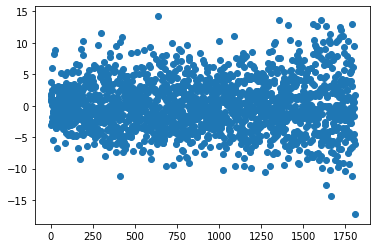

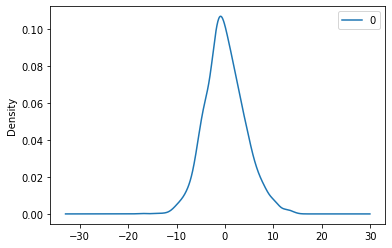

                 0
count  1807.000000
mean      0.000904
std       4.102881
min     -17.198744
25%      -2.588096
50%      -0.295092
75%       2.533252
max      14.210133
1808 1807


In [10]:
# fit model
series = df_verb_dist
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.scatter(np.arange(0, len(residuals)),residuals)
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())
print(len(series), len(residuals))

In [11]:
series = df_verb_dist
X = series.values
size = int(len(X) * 0.66)
train_vd, test_vd = X[0:size], X[size:len(X)]
history_vd = [x for x in train_vd]
predictions_vd = list()
# parameters can be adjusted. Given more time, I would do more analysis to optimize them better.
for t in range(len(test_vd)):
    model = ARIMA(history_vd, order=(7,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions_vd.append(yhat)
    obs = test_vd[t]
    history_vd.append(obs)
error_vd = mean_squared_error(test_vd, predictions_vd)
print('Test MSE: {}'.format(error_vd))


C:\Users\austi\newAnaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Test MSE: 21.84673050434441


In [12]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# seasonal difference
X = series.values
year = 365
differenced = difference(X, year)
# fit model
model = ARIMA(differenced, order=(7,1,1))
model_fit = model.fit(disp=0)
# out-of-sample forecast
forecast = model_fit.forecast(steps=35)[0]
history = [x for x in X]
out_of_sample_forecast_vd = []
for yhat in forecast:
    inverted = inverse_difference(history, yhat, year)
    out_of_sample_forecast_vd.append(inverted)
    history.append(inverted)


C:\Users\austi\newAnaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


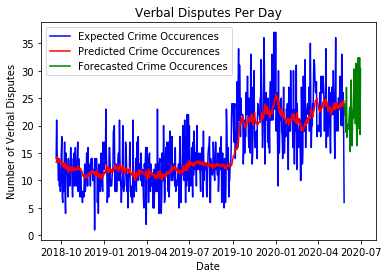

In [13]:
# plot
dates = list(df_verb_dist.index)
plt.plot(dates[len(train_vd):], test_vd, color='blue', label="Expected Crime Occurences")
plt.plot(dates[len(train_vd):], predictions_vd, color='red', label="Predicted Crime Occurences")
plt.plot(forecast_dates, out_of_sample_forecast_vd, color="Green", label='Forecasted Crime Occurences')
plt.ylabel('Number of Verbal Disputes')
plt.xlabel('Date')
plt.title('Verbal Disputes Per Day')
plt.legend(loc='upper left')
plt.show()


## Vandalism

The residuals appear to be normally distributed about 0, so we will proceed

C:\Users\austi\newAnaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:     NUMBER_OF_OFFENSES   No. Observations:                 1808
Model:                     ARMA(5, 0)   Log Likelihood               -5247.591
Method:                       css-mle   S.D. of innovations              4.408
Date:                Mon, 19 Oct 2020   AIC                          10509.182
Time:                        16:00:33   BIC                          10547.682
Sample:                    06-15-2015   HQIC                         10523.390
                         - 05-26-2020                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       12.1392      0.196     61.841      0.000      11.754      12.524
ar.L1.NUMBER_OF_OFFENSES     0.2251      0.023      9.586      0.000       0.179       0.

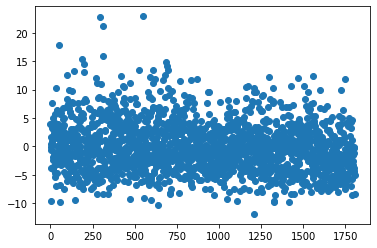

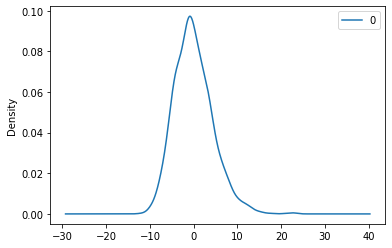

                 0
count  1808.000000
mean     -0.001047
std       4.409450
min     -11.895398
25%      -3.141654
50%      -0.446724
75%       2.652433
max      22.909243


In [14]:
# fit model
series = df_vandalism
model = ARIMA(series, order=(5,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.scatter(np.arange(0, len(residuals)),residuals)
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [15]:
series = df_vandalism
X = series.values
# size = int(len(X) * 0.66)
train_vand, test_vand = X[0:size], X[size:len(X)]
history_vand = [x for x in train_vand]
predictions_vand = list()
for t in range(len(test_vand)):
    model = ARIMA(history_vand, order=(5,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions_vand.append(yhat)
    obs = test_vand[t]
    history_vand.append(obs)
error = mean_squared_error(test_vand, predictions_vand)
print('Test MSE: {}'.format(error))


C:\Users\austi\newAnaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Test MSE: 17.85081425959931


C:\Users\austi\newAnaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


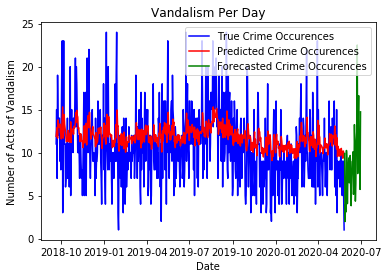

In [16]:
# seasonal difference
X = series.values
differenced = difference(X, year)
# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit(disp=0)
# out-of-sample forecast
forecast = model_fit.forecast(steps=35)[0]
history = [x for x in X]
out_of_sample_forecast_vand = []
for yhat in forecast:
    inverted = inverse_difference(history, yhat, year)
    out_of_sample_forecast_vand.append(inverted)
    history.append(inverted)


# plot
plt.plot(dates[len(train_vand):], test_vand, color='blue', label="True Crime Occurences")
plt.plot(dates[len(train_vand):], predictions_vand, color='red', label="Predicted Crime Occurences")
plt.plot(forecast_dates, out_of_sample_forecast_vand, color="Green", label='Forecasted Crime Occurences')
plt.legend(loc='upper right')
plt.ylabel('Number of Acts of Vandalism')
plt.xlabel('Date')
plt.title('Vandalism Per Day')
plt.show()

In [17]:
vd_forecast = [i[0] for i in out_of_sample_forecast_vd]
vand_forecast = [i[0] for i in out_of_sample_forecast_vand]

In [18]:
df = pd.DataFrame()
df['Dates'] = forecast_dates
df['VERBAL DISPUTE'] = vd_forecast
df['VANDALISM'] = vand_forecast
df.index = df.Dates
df = df.drop(['Dates'], axis=1)

### Below is the predicted daily count of Verbal Disputes and Vandalism for 5/27/2020 through 6/30/2020

In [19]:
df.to_csv('Crime_Predictions.csv')
df

,VERBAL DISPUTE,VANDALISM
Dates,,
2020-05-27,21.980927,9.886555
2020-05-28,23.964180,1.974845
2020-05-29,20.287916,3.922149
2020-05-30,18.785733,3.094162
2020-05-31,26.956630,10.243998
2020-06-01,17.866087,9.107697
2020-06-02,19.502198,4.057416
2020-06-03,19.287851,7.153823
2020-06-04,20.311536,8.268237
